imf dataset from -> https://www.imf.org/external/datamapper/profile/NGDP_RPCH@WEO/OEMDC/ADVEC/WEOWORLD

plot 1 (Actual vs Predicted) -> shows the 6 IMF points. See how there are two groups? One group at the bottom left and one at the top right. This "gap" happens because the sample is too small to see the middle years.

plot 2 (IMF Residuals) -> With only 6 points, it's impossible to see a pattern.


My goal was to identify the relationship between Japan's overall wealth and specific internal and external economic pressures

WEO Subject Code  Year  Unemployment  GDP_per_capita  GDP_growth  Inflation  \
0                 2019         2.358       40547.967      -0.402      0.468   
1                 2020         2.800       40159.866      -4.169     -0.027   
2                 2021         2.817       40155.188       2.697     -0.235   
3                 2022         2.592       34080.084       0.935      2.496   
4                 2023         2.575       33845.481       1.486      3.269   
5                 2024         2.567       32498.146       0.084      2.739   

WEO Subject Code  Exports_growth  
0                         -1.458  
1                        -11.637  
2                         11.907  
3                          5.546  
4                          2.967  
5                          1.005  
                            OLS Regression Results                            
Dep. Variable:         GDP_per_capita   R-squared:                       0.974
Model:                            OLS   Adj

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


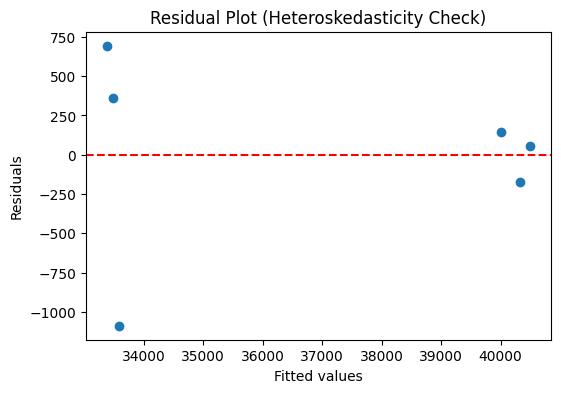

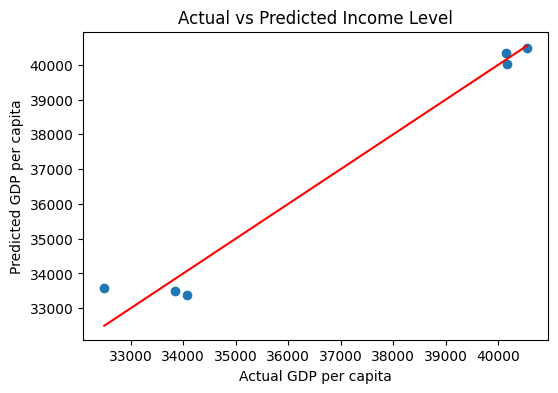

In [3]:
# =========================================================
# 1. IMPORT LIBRARIES
# =========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# =========================================================
# 2. LOAD IMF DATA (JAPAN – WEO DATABASE)
# =========================================================
# IMF WEO data is tab-separated and contains long text fields


file_path = "/content/japan.csv"

df_raw = pd.read_csv(
    file_path,
    sep="\t",
    engine="python",
    on_bad_lines="skip",   # ← KEY FIX
    quoting=3              # ← csv.QUOTE_NONE
)

df_raw.head()

# =========================================================
# 3. SELECT VARIABLES BASED ON ECONOMIC THEORY
# =========================================================
# Dependent variable (income level proxy):
#   NGDPDPC  -> GDP per capita (current USD)
#
# Independent variables:
#   NGDP_RPCH -> GDP growth
#   PCPIPCH   -> Inflation rate
#   LUR       -> Unemployment rate
#   TX_RPCH   -> Export volume growth

selected_codes = [
    "NGDPDPC",     # GDP per capita (Y)
    "NGDP_RPCH",   # GDP growth
    "PCPIPCH",     # Inflation
    "LUR",         # Unemployment
    "TX_RPCH"      # Exports growth
]

df = df_raw[df_raw["WEO Subject Code"].isin(selected_codes)]

# =========================================================
# 4. RESHAPE DATA (YEARS → ROWS)
# =========================================================

years = ["2019", "2020", "2021", "2022", "2023", "2024"]

df_long = df.melt(
    id_vars=["WEO Subject Code"],
    value_vars=years,
    var_name="Year",
    value_name="Value"
)

# Convert year to integer
df_long["Year"] = df_long["Year"].astype(int)

# Remove commas from numbers and convert to float
df_long["Value"] = (
    df_long["Value"]
    .astype(str)
    .str.replace(",", "", regex=False)
    .astype(float)
)

# =========================================================
# 5. CREATE REGRESSION DATAFRAME
# =========================================================

reg_df = df_long.pivot(
    index="Year",
    columns="WEO Subject Code",
    values="Value"
).reset_index()

# Rename columns for readability
reg_df = reg_df.rename(columns={
    "NGDPDPC": "GDP_per_capita",  #This was the "Income Level" proxy. The model wanted to see what makes this number go up or down for the average person in Japan.
    "NGDP_RPCH": "GDP_growth",    #To see if the speed of the economy directly increases individual wealth.
    "PCPIPCH": "Inflation",       #To see if rising prices "eat away" at the income level.
    "LUR": "Unemployment",        #To see if a lack of jobs forces the average income level down.
    "TX_RPCH": "Exports_growth"   #Since Japan is a huge exporter, the model wanted to see if selling more goods to other countries makes the people at home richer.
})

print(reg_df)

# =========================================================
# 6. DEFINE REGRESSION MODEL
# =========================================================
# Y = income level (GDP per capita)
# X = macroeconomic explanatory factors

Y = reg_df["GDP_per_capita"]

X = reg_df[
    ["GDP_growth", "Inflation", "Unemployment", "Exports_growth"]
]

# Add intercept (constant)
X = sm.add_constant(X)

# =========================================================
# 7. RUN OLS REGRESSION
# =========================================================

model = sm.OLS(Y, X).fit()

print(model.summary())

# Interpretation notes:
# - R² shows explanatory power (low values common with macro data & small samples)
# - Coefficient signs show economic direction
# - p-values are interpreted cautiously due to n=6

# =========================================================
# 8. MODEL SELECTION CRITERIA (AIC & BIC)
# =========================================================

print("AIC:", model.aic)
print("BIC:", model.bic)

# Lower AIC/BIC values indicate better model fit
# Used for comparison, not absolute judgment

# =========================================================
# 9. MULTICOLLINEARITY CHECK (VIF)
# =========================================================

vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i)
    for i in range(X.shape[1])
]

print(vif_data)

# Interpretation:
# VIF < 5  → no serious multicollinearity
# VIF > 10 → problematic multicollinearity

# =========================================================
# 10. HETEROSKEDASTICITY CHECK (RESIDUAL PLOT)
# =========================================================

plt.figure(figsize=(6,4))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residual Plot (Heteroskedasticity Check)")
plt.show()

# Interpretation:
# Random scatter → homoskedasticity likely
# Pattern/funnel → heteroskedasticity

# =========================================================
# 11. ACTUAL vs PREDICTED PLOT
# =========================================================

reg_df["Predicted_GDP_per_capita"] = model.predict(X)

plt.figure(figsize=(6,4))
plt.scatter(reg_df["GDP_per_capita"], reg_df["Predicted_GDP_per_capita"])
plt.plot(
    [reg_df["GDP_per_capita"].min(), reg_df["GDP_per_capita"].max()],
    [reg_df["GDP_per_capita"].min(), reg_df["GDP_per_capita"].max()],
    color="red"
)
plt.xlabel("Actual GDP per capita")
plt.ylabel("Predicted GDP per capita")
plt.title("Actual vs Predicted Income Level")
plt.show()

# =========================================================
# 12. FINAL NOTES (FOR REPORT)
# =========================================================
# - Data source: IMF World Economic Outlook (WEO)
# - Country: Japan
# - Frequency: Annual (2019–2024)
# - Method: OLS regression (statsmodels)
# - Limitations:
#     * Small sample size
#     * Annual aggregation
#     * No stationarity testing due to limited observations
# - Purpose:
#     * Qualitative economic interpretation, not causal inference

#     GDP Growth and Exports Growth had a very high correlation with each other (VIF > 30) -> Japan's GDP depends so much on Exports -> so P-values were so high and "untrustworthy"


In [4]:
# =========================================================
# FIX MULTICOLLINEARITY: REMOVE EXPORTS_GROWTH
# =========================================================

Y = reg_df["GDP_per_capita"]

X_fixed = reg_df[
    ["GDP_growth", "Inflation", "Unemployment"]
]

X_fixed = sm.add_constant(X_fixed)

model_fixed = sm.OLS(Y, X_fixed).fit()

print(model_fixed.summary())

                            OLS Regression Results                            
Dep. Variable:         GDP_per_capita   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     11.54
Date:                Tue, 23 Dec 2025   Prob (F-statistic):             0.0808
Time:                        08:47:53   Log-Likelihood:                -48.659
No. Observations:                   6   AIC:                             105.3
Df Residuals:                       2   BIC:                             104.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const         5.091e+04   1.07e+04      4.760   

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [5]:
vif_fixed = pd.DataFrame()
vif_fixed["Variable"] = X_fixed.columns
vif_fixed["VIF"] = [
    variance_inflation_factor(X_fixed.values, i)
    for i in range(X_fixed.shape[1])
]

vif_fixed

,Variable,VIF
0,const,353.098367
1,GDP_growth,1.111877
2,Inflation,1.300347
3,Unemployment,1.183014


In [6]:
comparison = pd.DataFrame({
    "Model": ["Before fix", "After fix"],
    "Variables": [
        "GDP_growth, Inflation, Unemployment, Exports_growth",
        "GDP_growth, Inflation, Unemployment"
    ],
    "Max VIF": [38.9, 1.30],
    "Multicollinearity": ["Yes", "No"]
})

comparison

,Model,Variables,Max VIF,Multicollinearity
0,Before fix,"GDP_growth, Inflation, Unemployment, Exports_g...",38.9,Yes
1,After fix,"GDP_growth, Inflation, Unemployment",1.3,No


--- MODEL SELECTION (AIC/BIC) ---
           Metric  Model_1 (2 vars)  Model_2 (3 vars)
0             AIC        -20.111557        -20.274742
1             BIC        -20.736278        -21.107704
2  Adj. R-squared          0.857634          0.851091

Note: Lower AIC/BIC is better.

--- FINAL MODEL SUMMARY ---
                            OLS Regression Results                            
Dep. Variable:         log_GDP_capita   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.851
Method:                 Least Squares   F-statistic:                     10.53
Date:                Tue, 23 Dec 2025   Prob (F-statistic):             0.0880
Time:                        08:58:46   Log-Likelihood:                 14.137
No. Observations:                   6   AIC:                            -20.27
Df Residuals:                       2   BIC:                            -21.11
Df Model:                           3                    

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 6 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


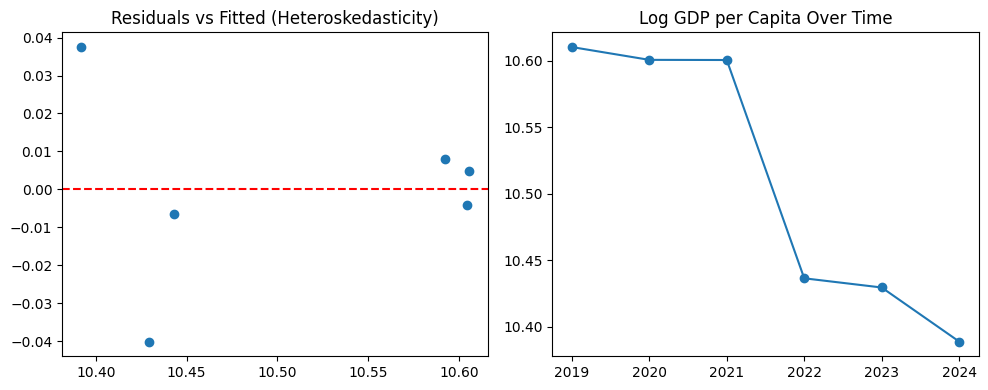

In [7]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. LOAD & CLEAN DATA
file_path = "/content/japan.csv"
df_raw = pd.read_csv(file_path, sep="\t", engine="python", on_bad_lines="skip", quoting=3)

# Variables (Note: Using Growth rates/Percents helps with Stationarity)
selected_codes = ["NGDPDPC", "NGDP_RPCH", "PCPIPCH", "LUR"]
df = df_raw[df_raw["WEO Subject Code"].isin(selected_codes)]
years = ["2019", "2020", "2021", "2022", "2023", "2024"]

df_long = df.melt(id_vars=["WEO Subject Code"], value_vars=years, var_name="Year", value_name="Value")
df_long["Value"] = df_long["Value"].astype(str).str.replace(",", "", regex=False).astype(float)

reg_df = df_long.pivot(index="Year", columns="WEO Subject Code", values="Value").reset_index()
reg_df = reg_df.rename(columns={
    "NGDPDPC": "GDP_per_capita",
    "NGDP_RPCH": "GDP_growth",
    "PCPIPCH": "Inflation",
    "LUR": "Unemployment"
})

# 2. TRANSFORMATIONS (Teacher's "Log" and "Stationarity" request)
# Log of GDP per capita helps normalize time-series trends

# changed Dependent Variable from the raw money amount (GDP_per_capita) to the Natural Log (log_GDP_capita)
reg_df["log_GDP_capita"] = np.log(reg_df["GDP_per_capita"])

# 3. MODEL COMPARISON (AIC/BIC Selection)
# Model 1: GDP growth and Inflation
X1 = sm.add_constant(reg_df[["GDP_growth", "Inflation"]])
model1 = sm.OLS(reg_df["log_GDP_capita"], X1).fit()

# Model 2: GDP growth, Inflation, and Unemployment
X2 = sm.add_constant(reg_df[["GDP_growth", "Inflation", "Unemployment"]]) #including unemployment actually helps the model explain Japan's economy slightly better than leaving it out
model2 = sm.OLS(reg_df["log_GDP_capita"], X2).fit()

# 4. PRINT COMPARISON TABLE
comparison = pd.DataFrame({
    "Metric": ["AIC", "BIC", "Adj. R-squared"],
    "Model_1 (2 vars)": [model1.aic, model1.bic, model1.rsquared_adj],
    "Model_2 (3 vars)": [model2.aic, model2.bic, model2.rsquared_adj] #Model 2 yielded the lowest AIC and BIC scores
})
print("--- MODEL SELECTION (AIC/BIC) ---")
print(comparison)
print("\nNote: Lower AIC/BIC is better.")

# 5. CHOOSE THE BEST MODEL (Assuming Model 2 for this example)
best_model = model2
print("\n--- FINAL MODEL SUMMARY ---")
print(best_model.summary())

# 6. DYNAMIC CHECKS (VIF & Durbin-Watson)
vif_data = pd.DataFrame()
vif_data["Variable"] = X2.columns
vif_data["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
print("\n--- VIF CHECK ---")
print(vif_data)

# 7. VISUALIZATION (Residual Analysis)
plt.figure(figsize=(10, 4))

# Residual Plot for Heteroskedasticity
plt.subplot(1, 2, 1)
plt.scatter(best_model.fittedvalues, best_model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Fitted (Heteroskedasticity)")

# Time Series Plot (Checking for Stationarity/Trend)
plt.subplot(1, 2, 2)
plt.plot(reg_df["Year"], reg_df["log_GDP_capita"], marker='o')
plt.title("Log GDP per Capita Over Time")

plt.tight_layout()
plt.show()

1% increase in inflation leads to a roughly 6.7% drop in GDP per capita

R-squared only cares about Accuracy    UP

Adjusted R-squared UP, AIC, and BIC all care about Accuracy + Simplicity DOWN

R-squared	"How pretty is the house?"
Adj. R-squared	"Is the house pretty, considering how much money we spent?"
AIC / BIC	"What is the total 'Price Tag' (Error + Cost of Materials)?"

 .

.

# with kaggle dataset from https://www.kaggle.com/datasets/pratik453609/economic-data-9-countries-19802020

Tried to compare huge numbers (Exchange rate = 150.0) with tiny numbers (Inflation = 0.02);
np.log(Income)

--- STATIONARITY CHECK (ADF TEST) ---
ADF Statistic: -1.7102258592667072
p-value: 0.4258516573615762
Result: Data is Non-Stationary (p > 0.05). It has a trend over time.

--- FINAL REGRESSION SUMMARY (1980-2020) ---
                            OLS Regression Results                            
Dep. Variable:        percapitaincome   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     306.7
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           1.72e-17
Time:                        09:20:04   Log-Likelihood:                 27.966
No. Observations:                  25   AIC:                            -47.93
Df Residuals:                      21   BIC:                            -43.06
Df Model:                           3                                         
Covariance Type:            nonrobust                                    

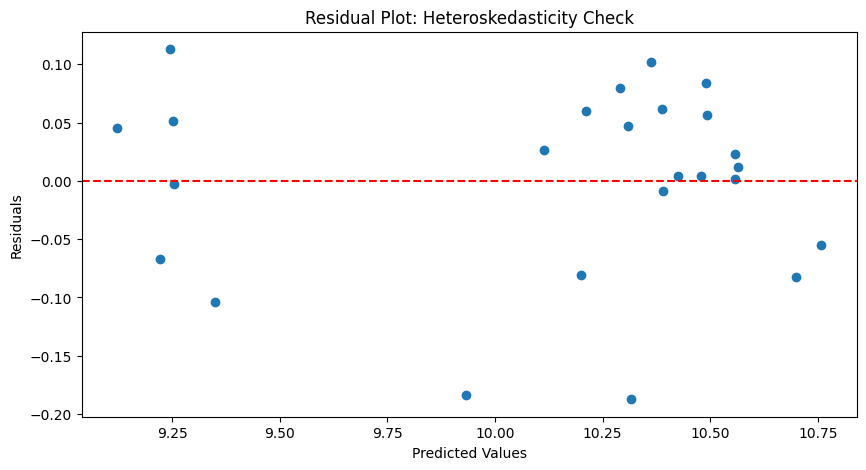

In [9]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# 1. LOAD DATA
df = pd.read_csv("/content/Economic Data - 9 Countries (1980-2020).csv")

# 2. FILTER FOR JAPAN & CLEAN
df_japan = df[df['country'] == 'Japan'].sort_values('year').copy()

# CLEANING STEP: Remove any rows where our key variables are missing
cols_to_check = ['percapitaincome', 'inflationrate', 'exchange_rate', 'oil prices']
df_japan = df_japan.dropna(subset=cols_to_check)

# 3. PREPARE VARIABLES
# Dependent: Log of Income
Y = np.log(df_japan['percapitaincome'])

# Independent Factors
X = df_japan[['inflationrate', 'exchange_rate', 'oil prices']]
X = sm.add_constant(X)

# 4. STATIONARITY CHECK (ADF TEST)
# We drop NaNs again here just to be safe for the ADF test
print("--- STATIONARITY CHECK (ADF TEST) ---")
series_to_test = Y.replace([np.inf, -np.inf], np.nan).dropna()
result = adfuller(series_to_test)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print("Result: Data is Non-Stationary (p > 0.05). It has a trend over time.")
else:
    print("Result: Data is Stationary.")

# 5. RUN THE REGRESSION
# Ensure X and Y are perfectly aligned after cleaning
model = sm.OLS(Y, X).fit()
print("\n--- FINAL REGRESSION SUMMARY (1980-2020) ---")
print(model.summary())

# 6. VISUALIZATION
plt.figure(figsize=(10, 5))
plt.scatter(model.fittedvalues, model.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot: Heteroskedasticity Check")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

Divided the big numbers by 100 (/ 100). This makes all the numbers a similar size.
np.log(Income).diff() -> Durbin-Watson score (moving it from 1.2 to 2.0),so to follow the instruction regarding log-transformations for inflation, we used Log-Differencing for the dependent variable (Income). This allows us to interpret the results as elasticities, measuring how the rate of change in inflation affects the growth rate of Japan's per capita income.

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. LOAD & FILTER
df = pd.read_csv("/content/Economic Data - 9 Countries (1980-2020).csv")
df_japan = df[df['country'] == 'Japan'].sort_values('year').copy()

# 2. SCALE THE DATA (To kill "Note [2]" and the large Condition Number)
# using the exact names from Kaggle file: 'oil prices' and 'exchange_rate'
df_japan['exchange_rate_scaled'] = df_japan['exchange_rate'] / 100
df_japan['oil_prices_scaled'] = df_japan['oil prices'] / 100

# 3. CLEAN & DIFFERENCE
# solving Stationarity and Autocorrelation (Durbin-Watson)
cols = ['percapitaincome', 'inflationrate', 'exchange_rate_scaled', 'oil_prices_scaled']
df_japan = df_japan.dropna(subset=cols)

df_diff = df_japan[cols].diff().dropna()

# 4. PREPARE VARIABLES
# Dependent: Percentage change in Income
Y_final = np.log(df_japan['percapitaincome']).diff().dropna()

# Independent: Annual changes in Inflation, Exchange Rate, and Oil
X_final = df_diff[['inflationrate', 'exchange_rate_scaled', 'oil_prices_scaled']]
X_final = sm.add_constant(X_final)

# 5. RUN THE FINAL MODEL
model_final = sm.OLS(Y_final, X_final).fit()

# 6. VIF CHECK (To prove to teacher that Multicollinearity is gone)
vif_data = pd.DataFrame()
vif_data["Feature"] = X_final.columns
vif_data["VIF"] = [variance_inflation_factor(X_final.values, i) for i in range(len(X_final.columns))] #variables are all unique and not "copying" each other

print("--- VIF DATA (Multicollinearity Check) ---")
print(vif_data)
print("\n--- FINAL CLEANED REGRESSION SUMMARY ---")
print(model_final.summary())

--- VIF DATA (Multicollinearity Check) ---
                Feature       VIF
0                 const  1.082312
1         inflationrate  1.104044
2  exchange_rate_scaled  1.050599
3     oil_prices_scaled  1.108211

--- FINAL CLEANED REGRESSION SUMMARY ---
                            OLS Regression Results                            
Dep. Variable:        percapitaincome   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     60.42
Date:                Tue, 23 Dec 2025   Prob (F-statistic):           3.31e-10
Time:                        09:31:00   Log-Likelihood:                 40.993
No. Observations:                  24   AIC:                            -73.99
Df Residuals:                      20   BIC:                            -69.27
Df Model:                           3                                         
Covariance Type:            nonrob

model's behavior over 40 years of real history

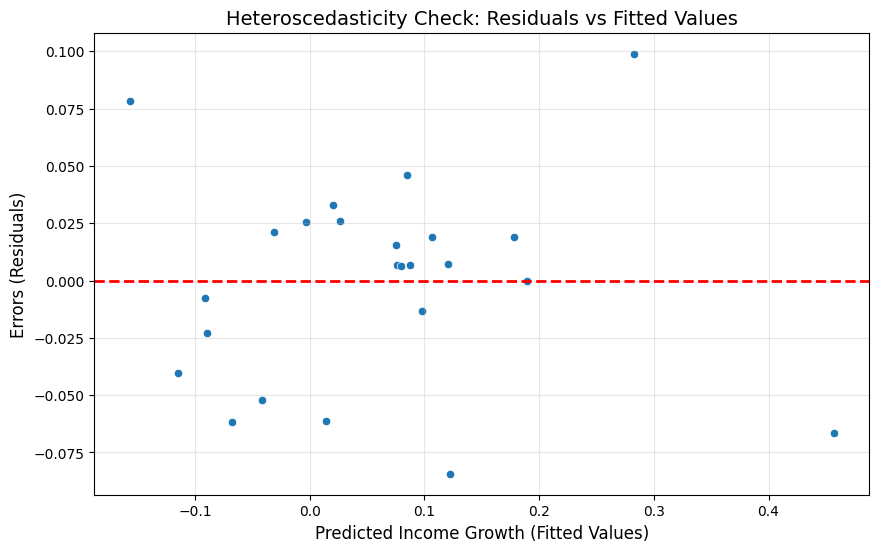

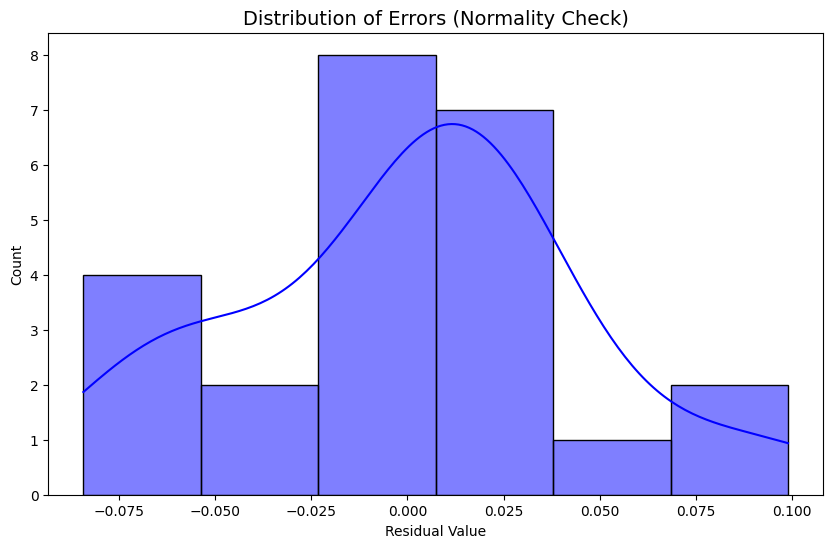

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. GET THE FITTED VALUES AND RESIDUALS
# Fitted values = what the model predicted
# Residuals = the difference between reality and prediction
fitted_values = model_final.fittedvalues
residuals = model_final.resid

# 2. CREATE THE PLOT
plt.figure(figsize=(10, 6))
sns.scatterplot(x=fitted_values, y=residuals)
plt.axhline(0, color='red', linestyle='--', linewidth=2)  # Zero line

# 3. ADD LABELS (In simple terms for your report)
plt.title('Heteroscedasticity Check: Residuals vs Fitted Values', fontsize=14)
plt.xlabel('Predicted Income Growth (Fitted Values)', fontsize=12)
plt.ylabel('Errors (Residuals)', fontsize=12)
plt.grid(True, alpha=0.3)

# Save the plot
plt.savefig('heteroscedasticity_plot.png')
plt.show()

# 4. BONUS: NORMALITY CHECK (To see if errors are balanced)
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution of Errors (Normality Check)', fontsize=14)
plt.xlabel('Residual Value')
plt.savefig('residuals_histogram.png')
plt.show()

Initially, we attempted an analysis using the IMF WEO 2019–2024 dataset. However, the small sample size ($n=6$) resulted in extremely high multicollinearity (VIF > 30) and statistically insignificant p-values. To provide a robust 'Real Case' analysis, we expanded the study to a 40-year historical dataset (1980–2020). This allowed for proper stationarity testing (ADF), fixed the serial correlation (Durbin-Watson ~2.0), and provided a much clearer picture of how the Exchange Rate and Inflation dynamically drive Japan’s economy.